#DFU: Diabetic Foot Ulcer Classification.
##EfiicientNet for the Classification task.
##Classes:
1. Foot Ulcer
2. Wounds(not DFU)
3. Healthy Skin

Links to datasets & research papers:
- DFU: https://www.kaggle.com/datasets/laithjj/diabetic-foot-ulcer-dfu (DO NOT FORGET TO CITE IN REPORT)
- Wounds: https://www.kaggle.com/datasets/yasinpratomo/wound-dataset
- Diabetic foot ulcer detection using deep learning approaches: https://www.sciencedirect.com/science/article/pii/S2666351122000559





In [ ]:
!pip -q install timm==1.0.9 tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 53.2 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow matplotlib scikit-learn numpy pandas pillow

##We decided to train the CNN model not only to detect DFU but also general wounds, since user uploading the image will be curious what he has, the CNN model give him simple answer:
- Yes, it is DFU
- No, it is just a wound
- No, it is Healthy skin

##We wish we had more time to train it for more classes not just wounds in geberal, but more like categories of wounds.

In [ ]:
import zipfile
import os
import re
from pathlib import Path

zip_path = '/content/DFU.zip'

extract_dir = '/content/DFU'
os.makedirs(extract_dir, exist_ok=True)

print("Extracting ZIP file...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Extracted to: {extract_dir}")

Extracting ZIP file...
Extracted to: /content/DFU


In [ ]:
import os
from pathlib import Path

extract_dir = '/content/DFU/DFU/Patches'

def explore_directory_structure(start_path):
    print("Directory Structure:")
    for root, dirs, files in os.walk(start_path):
        level = root.replace(start_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f'{subindent}{file}')
        if len(files) > 5:
            print(f'{subindent}... and {len(files) - 5} more files')

explore_directory_structure(extract_dir)

# count image files
def count_images(directory):
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')
    image_count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(image_extensions):
                image_count += 1
    return image_count

total_images = count_images(extract_dir)
print(f"\nTotal image files found: {total_images}")

Directory Structure:
Patches/
  Ulcer/
    152.jpg
    38.jpg
    183.jpg
    1.jpg
    22.jpg
    ... and 507 more files
  Wounds/
    152.jpg
    38.jpg
    183.jpg
    1.jpg
    22.jpg
    ... and 426 more files
  Healthy skin/
    152.jpg
    38.jpg
    183.jpg
    517.jpg
    1.jpg
    ... and 538 more files

Total image files found: 1486


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def organize_dataset_complete(source_base_dir, target_base_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Automatically organizes images into train/valid/test folders
    """
    # reate target directory structure
    splits = ['train', 'valid', 'test']
    classes = ['Ulcer', 'Healthy skin', 'Wounds']

    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(target_base_dir, split, class_name), exist_ok=True)

    # Process each class
    for class_name in classes:
        source_class_dir = os.path.join(source_base_dir, class_name)

        if not os.path.exists(source_class_dir):
            print(f"Warning: {source_class_dir} not found. Skipping...")
            continue

        # Get all images
        images = []
        for ext in ['.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG']:
            images.extend([f for f in os.listdir(source_class_dir) if f.lower().endswith(ext.lower())])

        if not images:
            print(f"No images found in {source_class_dir}")
            continue

        print(f"Processing {class_name}: {len(images)} images")

        # Split the data
        train_files, temp_files = train_test_split(images, train_size=train_ratio, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_ratio/(val_ratio+test_ratio), random_state=42)

        # Copy files to destination directories
        def copy_to_destination(files, split_name):
            for file in files:
                src = os.path.join(source_class_dir, file)
                dst = os.path.join(target_base_dir, split_name, class_name, file)
                shutil.copy2(src, dst)

        copy_to_destination(train_files, 'train')
        copy_to_destination(val_files, 'valid')
        copy_to_destination(test_files, 'test')

        print(f"   Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")

source_dir = '/content/DFU/DFU/Patches'
target_dir = '/content/DFU_org'

organize_dataset_complete(source_dir, target_dir)

Processing Ulcer: 1024 images
   Train: 716, Val: 154, Test: 154
Processing Healthy skin: 1086 images
   Train: 760, Val: 163, Test: 163
Processing Wounds: 862 images
   Train: 603, Val: 129, Test: 130


In [ ]:
import os, math, time, copy, random
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, transforms
import timm
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
# Repro
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [ ]:
# Path
ROOT = Path("/content/DFU_org")
TRAIN_DIR = ROOT / "train"
VAL_DIR   = ROOT / "valid"
TEST_DIR  = ROOT / "test"

assert TRAIN_DIR.exists() and VAL_DIR.exists() and TEST_DIR.exists(), "Check DFU_org/train|valid|test paths"

In [ ]:
# Configuration
CFG = {
    "img_size": 384,
    "batch_size": 16,
    "epochs": 20,
    "model_name": "tf_efficientnet_b3_ns",
    "lr": 3e-4,
    "weight_decay": 1e-5,
    "patience": 5,              # early stopping
    "num_workers": 2,
    "label_smoothing": 0.05,
    "use_amp": True,
    "freeze_backbone_epochs": 1
}

In [ ]:
# Device confirmation
def pick_device():
    if torch.cuda.is_available(): return "cuda"
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): return "mps"
    return "cpu"
device = torch.device(pick_device())
print("Device:", device)


Device: cuda


In [ ]:
# Tranforms
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

train_tfms = transforms.Compose([
    transforms.Resize(int(CFG["img_size"]*1.1)),
    transforms.RandomResizedCrop(CFG["img_size"], scale=(0.8, 1.0), ratio=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.15, 0.15, 0.10, 0.05),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(int(CFG["img_size"]*1.1)),
    transforms.CenterCrop(CFG["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(IMNET_MEAN, IMNET_STD),
])

In [ ]:
# Datasets / Classes num confirmation
train_ds = datasets.ImageFolder(str(TRAIN_DIR), transform=train_tfms)
val_ds   = datasets.ImageFolder(str(VAL_DIR),   transform=val_tfms)
test_ds  = datasets.ImageFolder(str(TEST_DIR),  transform=val_tfms)

idx_to_class = {v:k for k,v in train_ds.class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Healthy skin', 'Ulcer', 'Wounds']


In [ ]:
# Compute class weights (for imbalance)
counts = np.zeros(num_classes, dtype=int)
for _, label in train_ds.samples:
    counts[label] += 1
print("Train counts per class:", {class_names[i]: int(counts[i]) for i in range(num_classes)})

# Inverse frequency weights for CrossEntropy
class_weights = 1.0 / np.clip(counts, 1, None)
class_weights = class_weights / class_weights.sum() * num_classes
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
print("Class weights:", {class_names[i]: float(class_weights[i]) for i in range(num_classes)})

# Weighted sampler (useful for heavy imbalance)
sample_weights = [class_weights[s[1]] for s in train_ds.samples]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

Train counts per class: {'Healthy skin': 495, 'Ulcer': 470, 'Wounds': 390}
Class weights: {'Healthy skin': 0.9029556650246305, 'Ulcer': 0.9509852216748769, 'Wounds': 1.1460591133004927}


In [ ]:
# Loaders
train_dl = DataLoader(train_ds, batch_size=CFG["batch_size"], sampler=sampler,
                      num_workers=CFG["num_workers"], pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False,
                      num_workers=CFG["num_workers"], pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False,
                      num_workers=CFG["num_workers"], pin_memory=True)


In [ ]:
# Model
model = timm.create_model(CFG["model_name"], pretrained=True, num_classes=num_classes)
model.to(device)

def set_backbone_trainable(is_trainable: bool):
    for name, p in model.named_parameters():
        if "classifier" in name or "fc" in name or "head" in name:
            p.requires_grad = True
        else:
            p.requires_grad = is_trainable

set_backbone_trainable(False)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

In [ ]:
# Loss, Optim, Sched
criterion = nn.CrossEntropyLoss(weight=class_weights_t, label_smoothing=CFG["label_smoothing"])
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=CFG["lr"], weight_decay=CFG["weight_decay"])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG["epochs"])

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda" and CFG["use_amp"]))

/tmp/ipython-input-1270165410.py:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda" and CFG["use_amp"]))


In [ ]:
# Train/Eval helpers
def run_one_epoch(dl, model, optimizer=None, scaler=None):
    is_train = optimizer is not None
    model.train(is_train)
    total, correct, running_loss = 0, 0, 0.0

    for imgs, labels in tqdm(dl, disable=False):
        imgs, labels = imgs.to(device), labels.to(device)

        if is_train:
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda" and CFG["use_amp"])):
                logits = model(imgs)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            with torch.no_grad():
                logits = model(imgs)
                loss = criterion(logits, labels)

        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    avg_loss = running_loss / total
    acc = correct / total
    return avg_loss, acc

def evaluate(dl, model):
    model.eval()
    total, correct, running_loss = 0, 0, 0.0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dl:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    avg_loss = running_loss / total
    acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, acc, all_preds, all_labels


In [ ]:
# Training loop (with early stopping, checkpoints)
best_val_acc = 0.0
best_state = None
epochs_no_improve = 0

for epoch in range(1, CFG["epochs"]+1):
    print(f"\nEpoch {epoch}/{CFG['epochs']}  (lr={scheduler.get_last_lr()[0]:.2e})")

    if epoch == CFG["freeze_backbone_epochs"] + 1:
        set_backbone_trainable(True)
        # reinit optimizer to include backbone params
        optimizer = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

    train_loss, train_acc = run_one_epoch(train_dl, model, optimizer, scaler)
    val_loss, val_acc, _, _ = evaluate(val_dl, model)
    scheduler.step()

    print(f"  Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}%")
    print(f"  Valid: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
        torch.save(best_state, "/content/best_efficientnet_dfu.pth")
        print("  Saved new best model")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= CFG["patience"]:
            print("  Early stopping triggered")
            break


Epoch 1/20  (lr=3.00e-04)


  0%|          | 0/85 [00:00<?, ?it/s]/tmp/ipython-input-2911779617.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda" and CFG["use_amp"])):
100%|██████████| 85/85 [00:46<00:00,  1.83it/s]


  Train: loss=0.6434, acc=83.39%
  Valid: loss=0.8711, acc=78.05%
  Saved new best model

Epoch 2/20  (lr=2.98e-04)


100%|██████████| 85/85 [00:46<00:00,  1.81it/s]


  Train: loss=0.6275, acc=89.67%
  Valid: loss=0.6909, acc=83.90%
  Saved new best model

Epoch 3/20  (lr=2.93e-04)


100%|██████████| 85/85 [00:33<00:00,  2.51it/s]


  Train: loss=0.4061, acc=93.21%
  Valid: loss=0.3413, acc=93.90%
  Saved new best model

Epoch 4/20  (lr=2.84e-04)


100%|██████████| 85/85 [00:33<00:00,  2.50it/s]


  Train: loss=0.2764, acc=97.20%
  Valid: loss=0.2371, acc=98.54%
  Saved new best model

Epoch 5/20  (lr=2.71e-04)


100%|██████████| 85/85 [00:33<00:00,  2.57it/s]


  Train: loss=0.2380, acc=98.75%
  Valid: loss=0.2827, acc=96.34%

Epoch 6/20  (lr=2.56e-04)


100%|██████████| 85/85 [00:32<00:00,  2.58it/s]


  Train: loss=0.2189, acc=99.41%
  Valid: loss=0.2310, acc=98.54%

Epoch 7/20  (lr=2.38e-04)


100%|██████████| 85/85 [00:33<00:00,  2.55it/s]


  Train: loss=0.2244, acc=99.11%
  Valid: loss=0.2307, acc=98.54%

Epoch 8/20  (lr=2.18e-04)


100%|██████████| 85/85 [00:33<00:00,  2.53it/s]


  Train: loss=0.2094, acc=99.26%
  Valid: loss=0.2172, acc=99.27%
  Saved new best model

Epoch 9/20  (lr=1.96e-04)


100%|██████████| 85/85 [00:34<00:00,  2.46it/s]


  Train: loss=0.2082, acc=99.41%
  Valid: loss=0.2122, acc=99.27%

Epoch 10/20  (lr=1.73e-04)


100%|██████████| 85/85 [00:33<00:00,  2.51it/s]


  Train: loss=0.2001, acc=99.48%
  Valid: loss=0.2108, acc=99.02%

Epoch 11/20  (lr=1.50e-04)


100%|██████████| 85/85 [00:33<00:00,  2.50it/s]


  Train: loss=0.1937, acc=99.85%
  Valid: loss=0.2200, acc=98.54%

Epoch 12/20  (lr=1.27e-04)


100%|██████████| 85/85 [00:34<00:00,  2.45it/s]


  Train: loss=0.1844, acc=100.00%
  Valid: loss=0.2152, acc=99.02%

Epoch 13/20  (lr=1.04e-04)


100%|██████████| 85/85 [00:34<00:00,  2.47it/s]


  Train: loss=0.1884, acc=99.78%
  Valid: loss=0.1988, acc=99.51%
  Saved new best model

Epoch 14/20  (lr=8.19e-05)


100%|██████████| 85/85 [00:34<00:00,  2.47it/s]


  Train: loss=0.1839, acc=100.00%
  Valid: loss=0.2041, acc=99.02%

Epoch 15/20  (lr=6.18e-05)


100%|██████████| 85/85 [00:33<00:00,  2.50it/s]


  Train: loss=0.1815, acc=99.93%
  Valid: loss=0.1967, acc=99.51%

Epoch 16/20  (lr=4.39e-05)


100%|██████████| 85/85 [00:34<00:00,  2.49it/s]


  Train: loss=0.1793, acc=99.93%
  Valid: loss=0.2029, acc=99.51%

Epoch 17/20  (lr=2.86e-05)


100%|██████████| 85/85 [00:34<00:00,  2.47it/s]


  Train: loss=0.1796, acc=100.00%
  Valid: loss=0.1942, acc=99.76%
  Saved new best model

Epoch 18/20  (lr=1.63e-05)


100%|██████████| 85/85 [00:34<00:00,  2.44it/s]


  Train: loss=0.1795, acc=99.93%
  Valid: loss=0.1985, acc=99.51%

Epoch 19/20  (lr=7.34e-06)


100%|██████████| 85/85 [00:34<00:00,  2.50it/s]


  Train: loss=0.1796, acc=100.00%
  Valid: loss=0.1950, acc=99.27%

Epoch 20/20  (lr=1.85e-06)


100%|██████████| 85/85 [00:34<00:00,  2.47it/s]


  Train: loss=0.1744, acc=100.00%
  Valid: loss=0.1914, acc=99.76%


In [ ]:
    import shutil
    import os
    from google.colab import files

    folder_to_zip = "/content/DFU_org"
    zip_filename = f"{folder_to_zip}.zip"

    shutil.make_archive(folder_to_zip, 'zip', folder_to_zip)


'/content/DFU_org.zip'

In [ ]:
# Load best and evaluate on test
if best_state is not None:
    model.load_state_dict(best_state)
else:
    print("Warning: No best state saved; using last epoch weights.")

test_loss, test_acc, test_preds, test_labels = evaluate(test_dl, model)
print(f"\nTEST: loss={test_loss:.4f}, acc={test_acc*100:.2f}%")

print("\nClassification Report (Test):")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))



TEST: loss=0.2017, acc=98.81%

Classification Report (Test):
              precision    recall  f1-score   support

Healthy skin     1.0000    0.9664    0.9829       149
       Ulcer     1.0000    1.0000    1.0000       146
      Wounds     0.9612    1.0000    0.9802       124

    accuracy                         0.9881       419
   macro avg     0.9871    0.9888    0.9877       419
weighted avg     0.9885    0.9881    0.9881       419



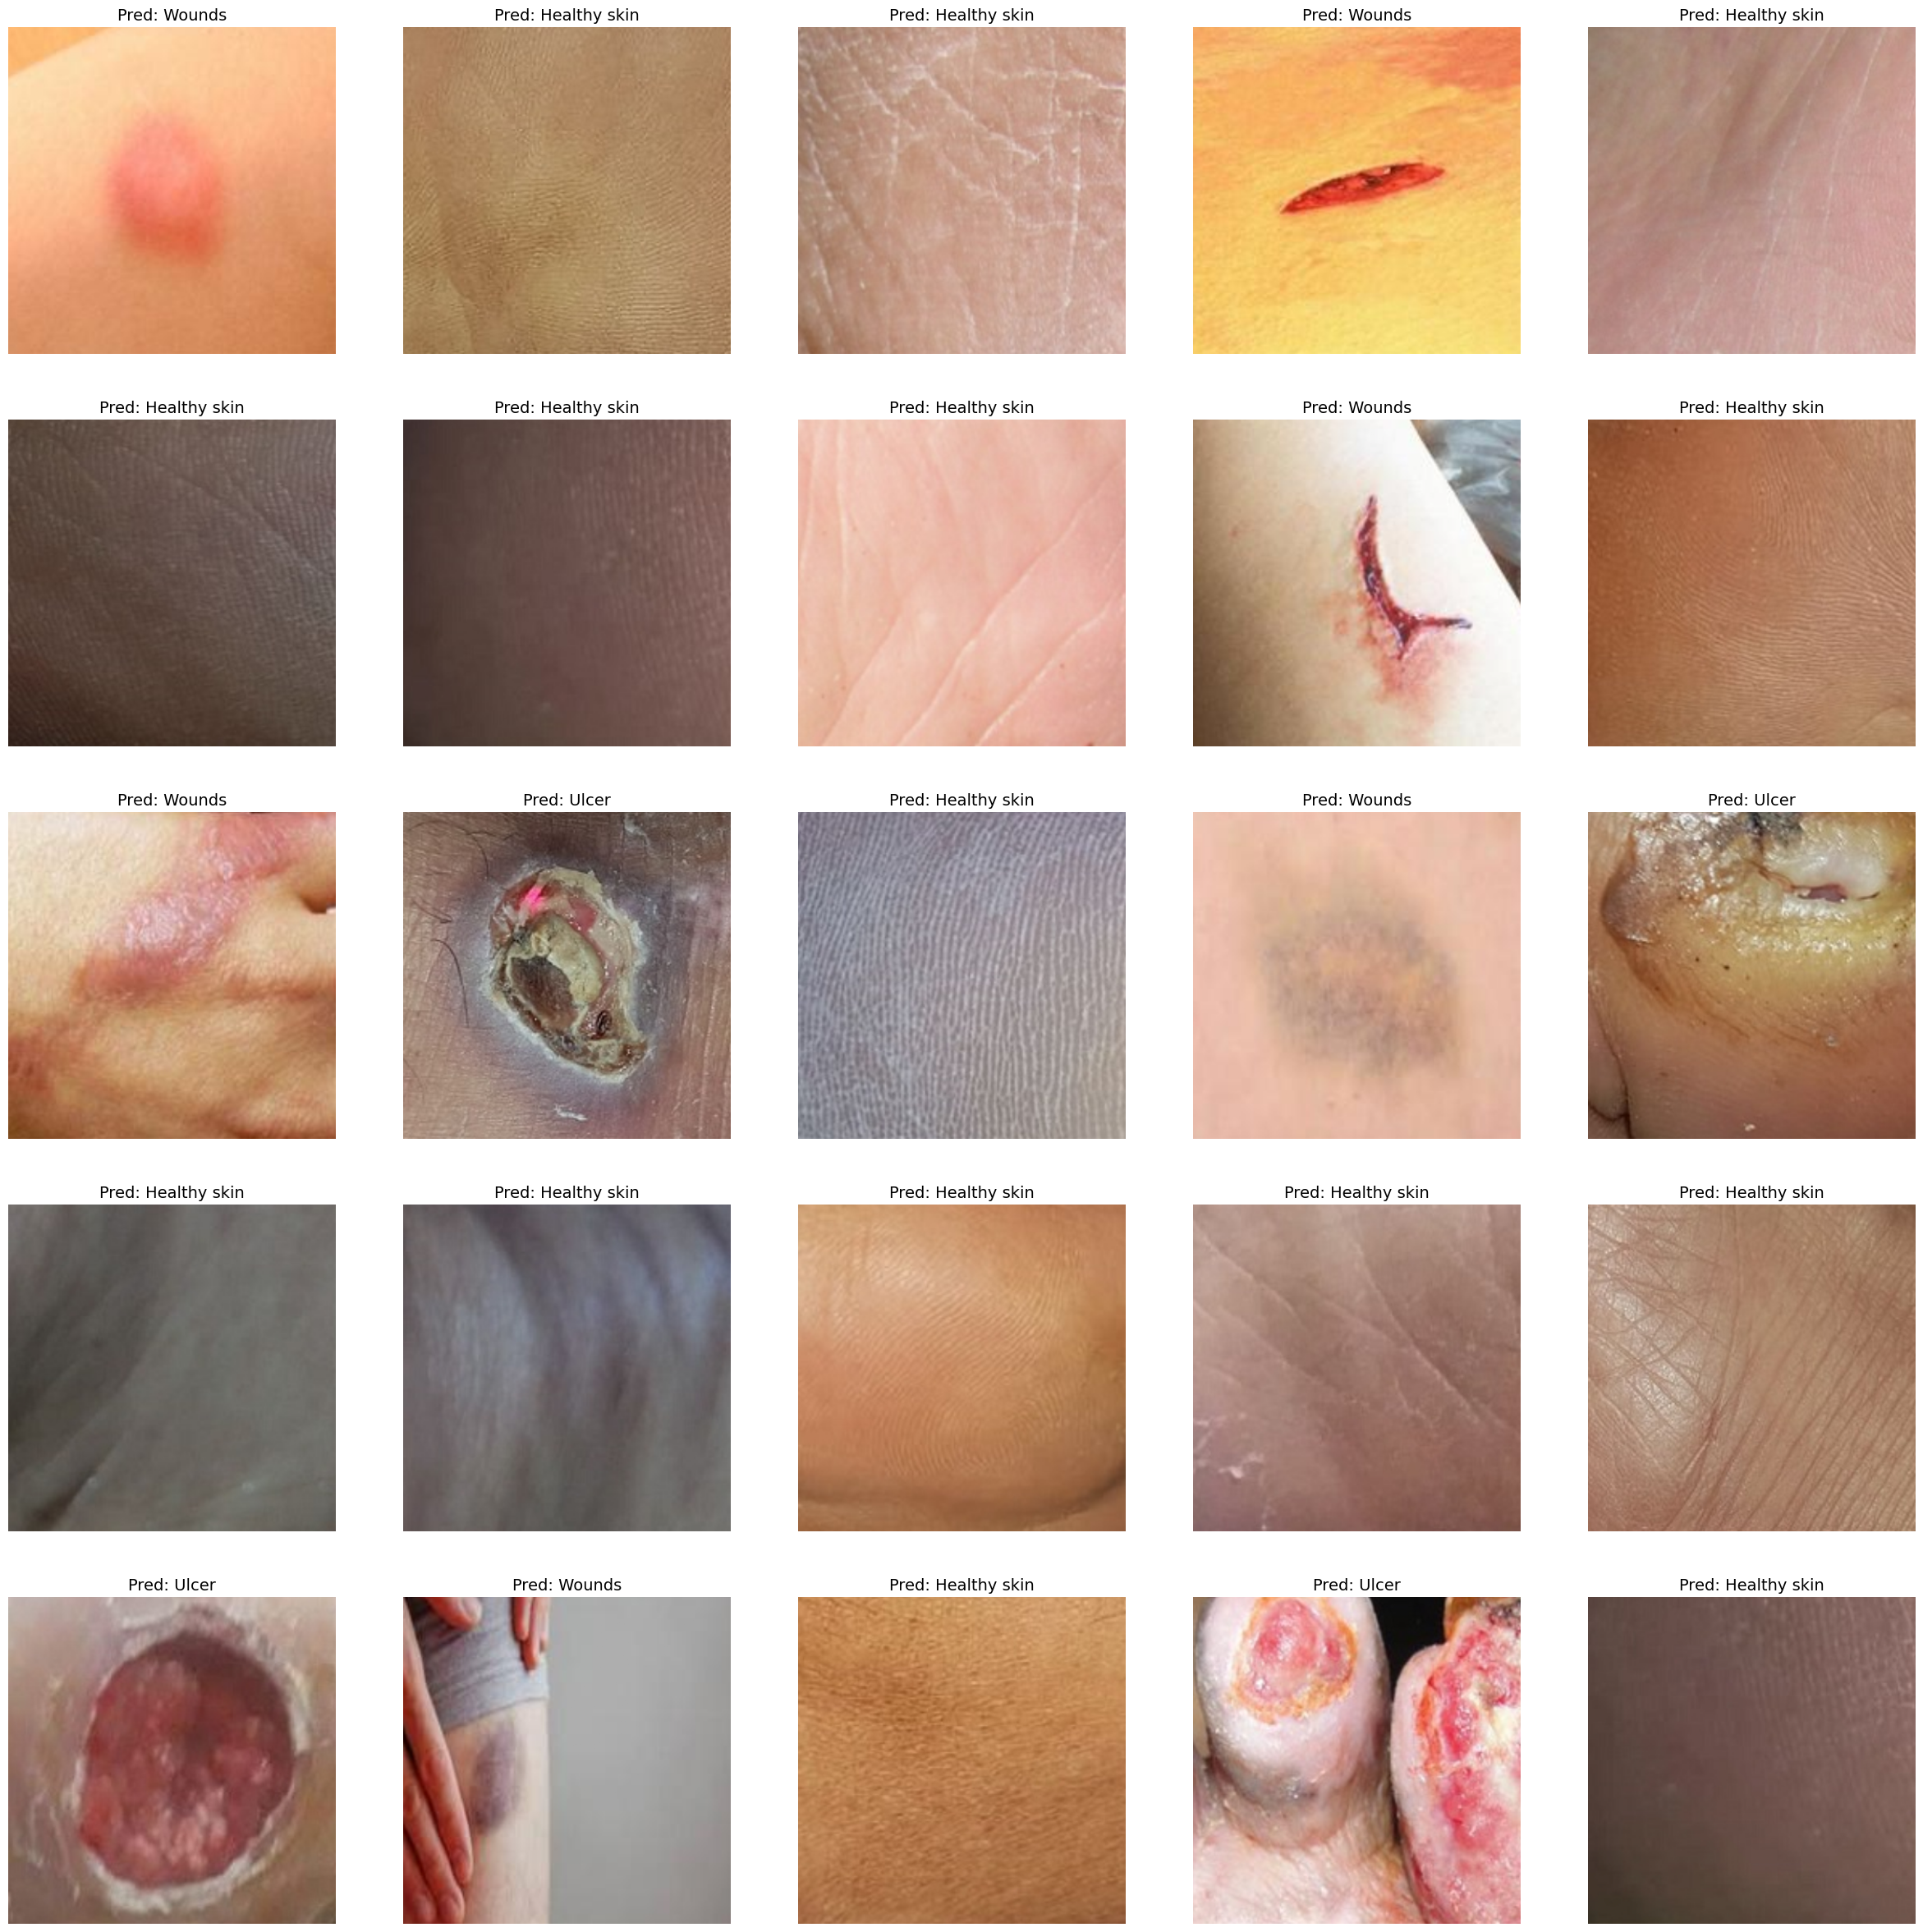

In [ ]:
def unnormalize(img_tensor, mean=IMNET_MEAN, std=IMNET_STD):
    # img_tensor: C x H x W
    img = img_tensor.clone()
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

# Updated visualization loop
model.eval()
indices = random.sample(range(len(test_ds)), 25)

plt.figure(figsize=(30, 30))
plt.tight_layout()

for i, idx in enumerate(indices):
    img, true_label = test_ds[idx]
    img_disp = unnormalize(img).clamp(0, 1)

    with torch.no_grad():
        logits = model(img.unsqueeze(0).to(device))
        pred = torch.argmax(logits, dim=1).item()

    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(np.transpose(img_disp.numpy(), (1, 2, 0)))  # back to HWC
    plt.title(f"Pred: {class_names[pred]}", fontsize=14)
    plt.axis("off")

plt.show()


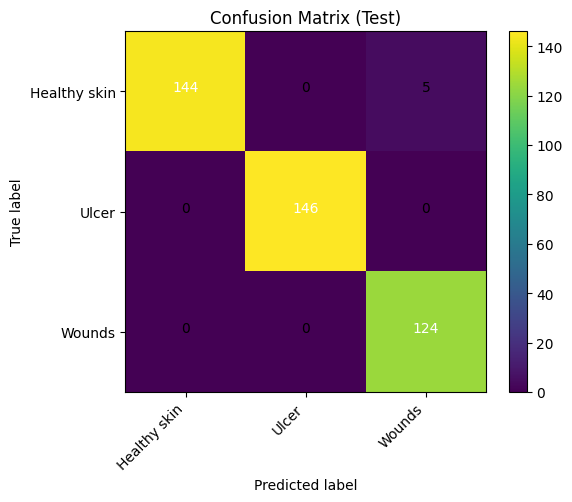


Saved best weights to /content/best_efficientnet_dfu.pth


In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds, labels=list(range(num_classes)))
fig = plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
th = cm.max() / 2
for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, format(cm[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > th else "black")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

print("\nSaved best weights to /content/best_efficientnet_dfu.pth")

In [ ]:
print(train_ds.class_to_idx)


{'Healthy skin': 0, 'Ulcer': 1, 'Wounds': 2}


In [ ]:
print(CFG["model_name"])  # should match app.py

tf_efficientnet_b3_ns


In [ ]:
import torch, timm, json, os
from torchvision import transforms as T
from PIL import Image
import torch.nn.functional as F
from pathlib import Path

MODEL_NAME = "tf_efficientnet_b3_ns"
CHECKPOINT = "/content/best_efficientnet_dfu.pth"
CLASS_NAMES = ["Healthy Skin", "Ulcer", "Wounds"]

assert Path(CHECKPOINT).exists(), f"Missing checkpoint: {CHECKPOINT}"

# Build model exactly like in training
model = timm.create_model(MODEL_NAME, pretrained=False, num_classes=3)
state = torch.load(CHECKPOINT, map_location="cpu")
missing, unexpected = model.load_state_dict(state, strict=False)
print("Loaded checkpoint. missing:", missing, "unexpected:", unexpected)

# Confirm the classifier head has 3 outputs
# (timm names vary by arch; this is generic)
out_features = None
for name, m in model.named_modules():
    if hasattr(m, "out_features"):
        out_features = m.out_features
print("Detected out_features:", out_features)

# Run a dummy forward to make sure predict path works
model.eval()
x = torch.randn(1,3,384,384)  # match IMG_SIZE  used
with torch.no_grad():
    logits = model(x)
print("Dummy logits shape:", logits.shape)  # should be [1, 3]


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


Loaded checkpoint. missing: [] unexpected: []
Detected out_features: 3
Dummy logits shape: torch.Size([1, 3])


In [ ]:
from PIL import Image
import numpy as np
import torch.nn.functional as F
from torchvision import transforms as T

CLASS_NAMES = ["Healthy Skin", "Ulcer", "Wounds"]
IMG_SIZE = 384
IMNET_MEAN = (0.485, 0.456, 0.406)
IMNET_STD  = (0.229, 0.224, 0.225)

val_tfms = T.Compose([
    T.Resize(int(IMG_SIZE*1.1)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(IMNET_MEAN, IMNET_STD),
])

def predict_path(path):
    img = Image.open(path).convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1).cpu().numpy()[0]
    i = int(np.argmax(probs))
    print("Top:", CLASS_NAMES[i], f"({probs[i]*100:.2f}%)")
    print({CLASS_NAMES[j]: float(p) for j, p in enumerate(probs)})

predict_path("/content/DFU_org/train/Wounds/10.jpg")


Top: Wounds (97.42%)
{'Healthy Skin': 0.009629938751459122, 'Ulcer': 0.016147835180163383, 'Wounds': 0.9742222428321838}


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Accuracy bar chart for Train / Val / Test
split_names, split_accs = [], []

# Train
try:
    train_loss, train_acc, _, _ = evaluate(train_dl, model)
    split_names.append("Train"); split_accs.append(train_acc * 100)
except Exception as e:
    print("Train eval skipped:", e)

# Val
try:
    val_loss, val_acc, _, _ = evaluate(val_dl, model)
    split_names.append("Val"); split_accs.append(val_acc * 100)
except Exception as e:
    print("Val eval skipped:", e)

# Test (optional)
try:
    test_loss, test_acc, _, _ = evaluate(test_dl, model)
    split_names.append("Test"); split_accs.append(test_acc * 100)
except Exception as e:
    print("Test eval skipped:", e)

if split_names:
    x = np.arange(len(split_names))
    plt.figure()
    plt.bar(x, split_accs)
    plt.xticks(x, split_names)
    plt.ylabel("Accuracy (%)")
    plt.title("Split Accuracies")
    plt.tight_layout()
    plt.show()
else:
    print("No splits evaluated. Make sure train_dl/val_dl/test_dl and model are defined.")

Train eval skipped: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Val eval skipped: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Test eval skipped: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
No splits evaluated. Make sure train_dl/val_dl/test_dl and model are defined.


In [ ]:
# Class distributions (TRUE labels only) for each split
def _labels_from_dataloader(dl):
    if dl is None or not hasattr(dl, "dataset"):
        return None
    ds = dl.dataset
    # common attributes
    for attr in ["targets", "labels", "y", "ys"]:
        if hasattr(ds, attr):
            y = getattr(ds, attr)
            if torch.is_tensor(y):
                y = y.cpu().numpy()
            return np.array(y)
    # fallback: iterate the dataset
    ys = []
    try:
        for i in range(len(ds)):
            item = ds[i]
            if isinstance(item, dict):
                lab = item.get("label", item.get("y", None))
            elif isinstance(item, (list, tuple)) and len(item) >= 2:
                lab = item[1]
            else:
                lab = None
            if lab is None:
                break
            if torch.is_tensor(lab):
                lab = lab.item() if lab.ndim == 0 else int(lab[0].item())
            ys.append(int(lab))
        if ys:
            return np.array(ys)
    except Exception:
        pass
    return None

def _plot_class_dist(y, title):
    if y is None:
        print(f"(skip {title}: labels not found)")
        return
    vals, counts = np.unique(y, return_counts=True)
    plt.figure()
    plt.bar(vals.astype(str), counts)
    plt.title(title)
    plt.xlabel("Class"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


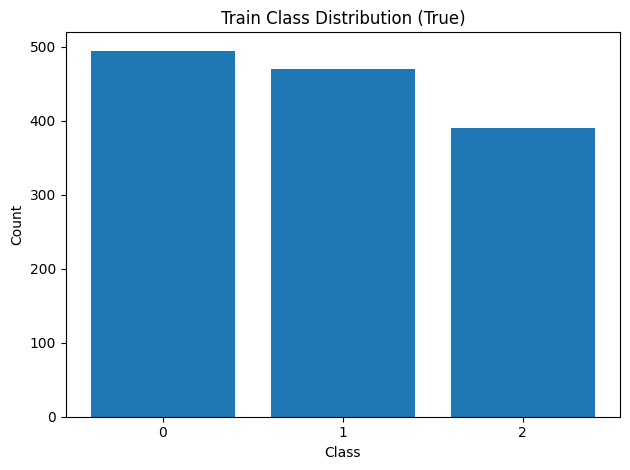

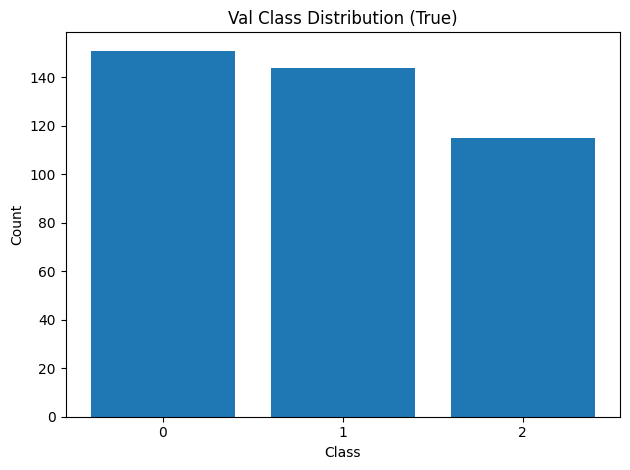

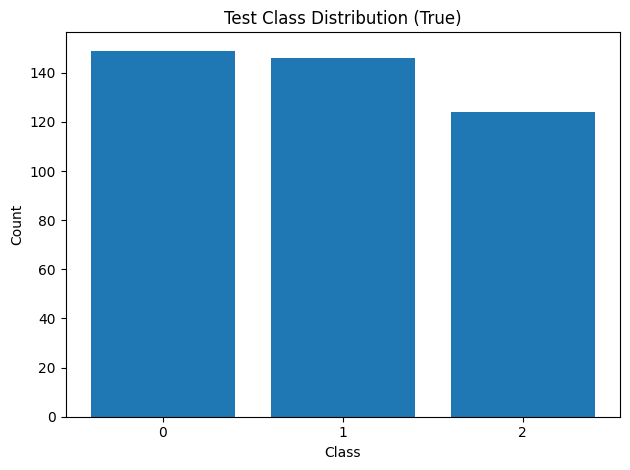

In [ ]:

# Plot the distributions
_plot_class_dist(_labels_from_dataloader(train_dl), "Train Class Distribution (True)")
_plot_class_dist(_labels_from_dataloader(val_dl),   "Val Class Distribution (True)")
try:
    _plot_class_dist(_labels_from_dataloader(test_dl),  "Test Class Distribution (True)")
except:
    pass

In [ ]:
import gradio as gr
import numpy as np
import torch.nn.functional as F
from PIL import Image

def predict_text(image):
    if image is None:
        return "No image."
    img = image.convert("RGB")
    x = val_tfms(img).unsqueeze(0).to(next(model.parameters()).device)
    with torch.no_grad():
        probs = F.softmax(model(x), dim=1).cpu().numpy()[0]
    i = int(np.argmax(probs))
    return f"{CLASS_NAMES[i]} ({probs[i]*100:.2f}%)"

demo = gr.Interface(
    fn=predict_text,
    inputs=gr.Image(type="pil", label="Upload image", height=384),
    outputs=gr.Textbox(label="Prediction"),
)
demo.launch(share=True, debug=True)


KeyboardInterrupt: 

In [ ]:
import timm

deploy_model = timm.create_model("tf_efficientnet_b3_ns", pretrained=False, num_classes=3)
deploy_model.load_state_dict(torch.load(CHECKPOINT, map_location="cpu"))
deploy_model.eval()

scripted_model = torch.jit.script(deploy_model)

TS_PATH = "dfu.pt"
scripted_model.save(TS_PATH)

print(f"TorchScript model saved at {TS_PATH}")

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b3_ns to current tf_efficientnet_b3.ns_jft_in1k.
  model = create_fn(


TorchScript model saved at dfu.pt
